In [1]:
%matplotlib inline
from sklearn.model_selection import train_test_split

from models import *

def Volatile(x):
    return Variable(x, volatile=True)

In [3]:
batch_size = 8
total_minibatches = Data.create_minibatches('resnet_v1_50', 'block3', batch_size)

X_train, X_test, y_train, y_test = train_test_split([i[0] for i in total_minibatches], [i[1] for i in total_minibatches], test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15)



# net = Fetures2ECoGTrans(features_dim=X_test[0].shape[3], hidden_dim=y_test[0].shape[1])
net = Fetures2ECoGTrans(features_dim=X_test[0].shape[3], hidden_dim=int(X_test[0].shape[3]/8))
opt = torch.optim.RMSprop(net.parameters(), lr=0.001)
mse = torch.nn.MSELoss()

n_train = len(y_train)
epoch = 0
max_epochs = 50
min_loss = np.inf
n_valid = len(y_valid)
while epoch < max_epochs:
    sum_loss = 0
    for idx, t in enumerate(X_train):
        net.zero_grad()
        w, output = net(Variable(t))
        loss = mse(output, Variable(y_train[idx]))
        loss.backward()
        opt.step()
        sum_loss += loss.data[0]
    epoch += 1
    print('[{:2d}] {:5.10f}'.format(epoch, sum_loss / n_train))
    sum_loss = 0
    for idx, t in enumerate(X_valid):
        w, output = net(Volatile(t))
        loss = mse(output, Volatile(y_valid[idx]))
        sum_loss += loss.data[0]

    valid_loss = sum_loss / n_valid
    print('valid loss: {:5.10f}'.format(valid_loss))
    if (min_loss > valid_loss):
        min_loss = valid_loss
    else:
        break

[ 1] 0.3269975924
valid loss: 0.1096947477
[ 2] 0.1279346242
valid loss: 0.1070823227
[ 3] 0.1258631491
valid loss: 0.1064910035
[ 4] 0.1246161390
valid loss: 0.1063125316
[ 5] 0.1237108523
valid loss: 0.1062480716
[ 6] 0.1229792099
valid loss: 0.1062195668
[ 7] 0.1223520661
valid loss: 0.1062020548
[ 8] 0.1217955309
valid loss: 0.1061878984
[ 9] 0.1212909417
valid loss: 0.1061752281
[10] 0.1208269501
valid loss: 0.1061640179
[11] 0.1203959981
valid loss: 0.1061546608
[12] 0.1199926776
valid loss: 0.1061475309
[13] 0.1196129210
valid loss: 0.1061428276
[14] 0.1192535362
valid loss: 0.1061406943
[15] 0.1189119673
valid loss: 0.1061411016


In [4]:
n_valid = len(y_test)
sum_loss = 0
# per_elec_target = np.empty((0, y_test[0].shape[1]))
# per_elec_output = np.empty((0, y_test[0].shape[1]))
per_elec_target = []
per_elec_output = []
for s in y_test:
    per_elec_target.extend(list(s))
    # per_elec_target = np.append(per_elec_target, np.array(s), axis=0)

for idx, t in enumerate(X_test):
    w, output = net(Volatile(t))
    per_elec_output.extend(list(output.data))
    loss = mse(output, Volatile(y_test[idx]))
    sum_loss += loss.data[0]


print('valid loss: {:5.3f}'.format(sum_loss / n_valid))

valid loss: 0.126


In [6]:
print ("Pearson correleation (r, p)")
stats.pearsonr(per_elec_target, per_elec_output)

Pearson correleation (r, p)


(0.18967502409280443, 1.0172439013513249e-07)

Visual electrode 100 samples. Target in blue. Net output in green


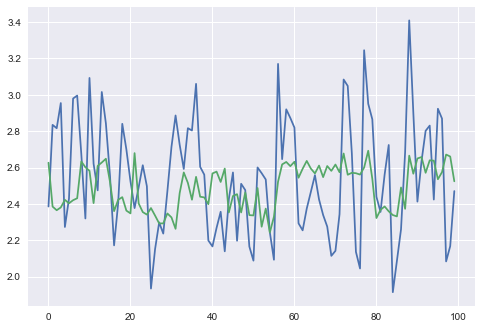

In [7]:
print("Visual electrode 100 samples. Target in blue. Net output in green")
plt.plot(per_elec_target[0:100])
plt.plot(per_elec_output[0:100])
plt.show()